<a href="https://colab.research.google.com/github/nadaz10/NLP-using-BERT/blob/main/NLP_project_using_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'nlp-getting-started:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F17777%2F869809%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240411%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240411T225705Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dbe1b72a55ec5ce2395a6166c00269cfdc0ace41edb5c264e4c4d94cc362fece081f7695977b3a89323b78d095cfb1beed4ba58ed3dcb62a770ae943588ff1d8793f12e5fb6e2524a96297ff6121e4ea780d37bbd93a0863b5b45059a138e41d013cdb3d8a693f6f4782384346e629074f3872dab4b934f28da3ea2e63b0f35448e1f7b8770b0197b7aa30f4eac446514135bc62baf0d9ef341979a915f7af41fdba4ffd71a28b7d6c8b952ccd17ef2aa4aacafce5787c575925df1785a5c0da17854d2be7016020837aa0260b7243a1daa516da2b7c35f4d49614a25f8114b8eab1d5af848a7faf1b621a12c8bf80da97c843b81d04d5806fd566d996597d662'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 607343 bytes downloaded
Downloaded and uncompressed: nlp-getting-started
Data source import complete.


## NLP Tutorial

NLP - or *Natural Language Processing* - is shorthand for a wide array of techniques designed to help machines learn from text. Natural Language Processing powers everything from chatbots to search engines, and is used in diverse tasks like sentiment analysis and machine translation.

In this tutorial we'll look at this competition's dataset, use a simple technique to process it, build a machine learning model, and submit predictions for a score!

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
import torch
from torch.utils.data import DataLoader, Dataset
from nltk import bigrams
from nltk.corpus import stopwords
# Download NLTK stopwords
import nltk
nltk.download('stopwords')

from collections import Counter
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import seaborn as sns

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_df = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
test_df = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

### A quick look at our data

Let's look at our data... first, an example of what is NOT a disaster tweet.

In [ ]:
train_df

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [ ]:
train_df[train_df["target"] == 0]["text"].values[1]

'I love fruits'

And one that is:

In [ ]:
train_df[train_df["target"] == 1]["text"].values[1]

'Forest fire near La Ronge Sask. Canada'

Data Tokenization:


In [ ]:
class TweetDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Initialize tokenizer and encode texts
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
train_dataset = TweetDataset(train_df['text'], train_df['target'], tokenizer, max_len=128)
# test_dataset = TweetDataset(test_texts, test_labels, tokenizer, max_len=128)


In [ ]:

# Extract bigrams from tokenized text
train_tokenized_texts = [tokenizer.tokenize(text) for text in train_df['text']]
train_bigrams = [list(bigrams(tokens)) for tokens in train_tokenized_texts]

# Flatten the list of bigrams
flat_bigrams = [bigram for sublist in train_bigrams for bigram in sublist]

# Calculate the frequency of each bigram
bigram_freq = Counter(flat_bigrams)

# Print the most common bigrams
print("Most common bigrams:")
for bigram, freq in bigram_freq.most_common(10):
    print(bigram, ":", freq)


Most common bigrams:
('/', 't') : 4789
('/', '/') : 4742
('t', '.') : 4738
(':', '/') : 4726
('.', 'co') : 4717
('co', '/') : 4717
('http', ':') : 4308
('.', '.') : 2379
('?', '?') : 1892
("'", 's') : 793


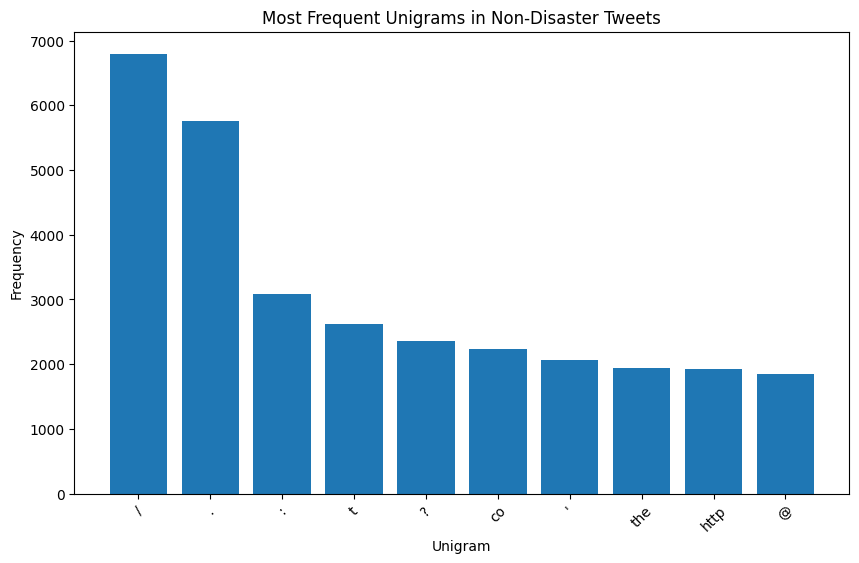

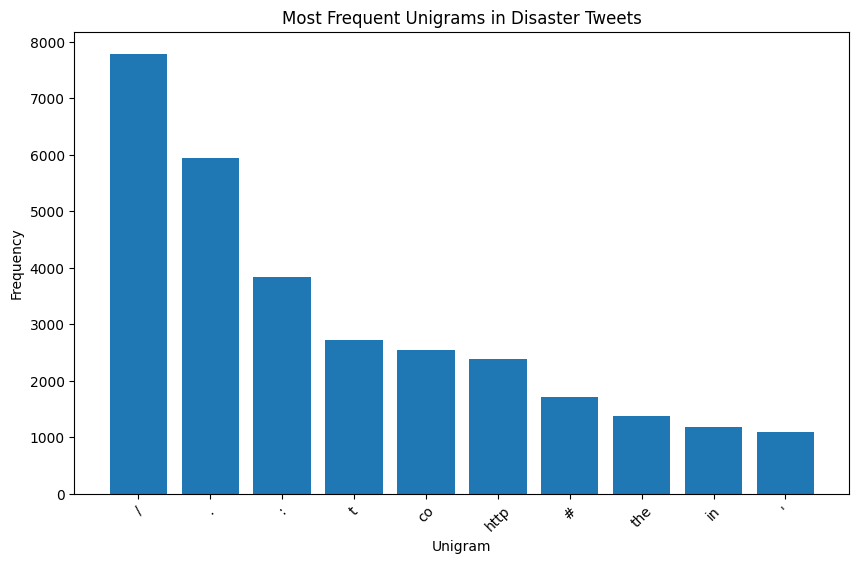

In [ ]:


# Filter tweets based on labels
non_disaster_tweets = [train_df['text'][i] for i in range(len(train_df['text'])) if train_df['target'][i] == 0]
disaster_tweets = [train_df['text'][i] for i in range(len(train_df['text'])) if train_df['target'][i] == 1]

# Tokenize tweets
non_disaster_tokenized_texts = [tokenizer.tokenize(text) for text in non_disaster_tweets]
disaster_tokenized_texts = [tokenizer.tokenize(text) for text in disaster_tweets]

# Flatten the list of tokens
flat_non_disaster_tokens = [token for sublist in non_disaster_tokenized_texts for token in sublist]
flat_disaster_tokens = [token for sublist in disaster_tokenized_texts for token in sublist]

# Calculate the frequency of each unigram
non_disaster_unigram_freq = Counter(flat_non_disaster_tokens)
disaster_unigram_freq = Counter(flat_disaster_tokens)

# Plot the most frequent unigrams for non-disaster tweets
plt.figure(figsize=(10, 6))
plt.bar(*zip(*non_disaster_unigram_freq.most_common(10)))
plt.title('Most Frequent Unigrams in Non-Disaster Tweets')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Plot the most frequent unigrams for disaster tweets
plt.figure(figsize=(10, 6))
plt.bar(*zip(*disaster_unigram_freq.most_common(10)))
plt.title('Most Frequent Unigrams in Disaster Tweets')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()


we need to clean the data to have a closer look

In [ ]:

# Define function for data cleaning
def clean_text(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)
    # Remove special characters and punctuation
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Convert to lowercase
    text = text.lower()

        # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = text.split()
    text = ' '.join([token for token in tokens if token not in stop_words])


    return text

# Apply data cleaning to tweets
train_texts_cleaned = [clean_text(text) for text in train_df['text']]

# Filter tweets based on labels
non_disaster_tweets_cleaned = [train_texts_cleaned[i] for i in range(len(train_texts_cleaned)) if train_df['target'][i] == 0]
disaster_tweets_cleaned = [train_texts_cleaned[i] for i in range(len(train_texts_cleaned)) if train_df['target'][i] == 1]

# Tokenize cleaned tweets
non_disaster_tokenized_texts_cleaned = [tokenizer.tokenize(text) for text in non_disaster_tweets_cleaned]
disaster_tokenized_texts_cleaned = [tokenizer.tokenize(text) for text in disaster_tweets_cleaned]


<ipython-input-29-c591c14b550d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[pair[0] for pair in clean_non_disaster_unigram_freq.most_common(10)],


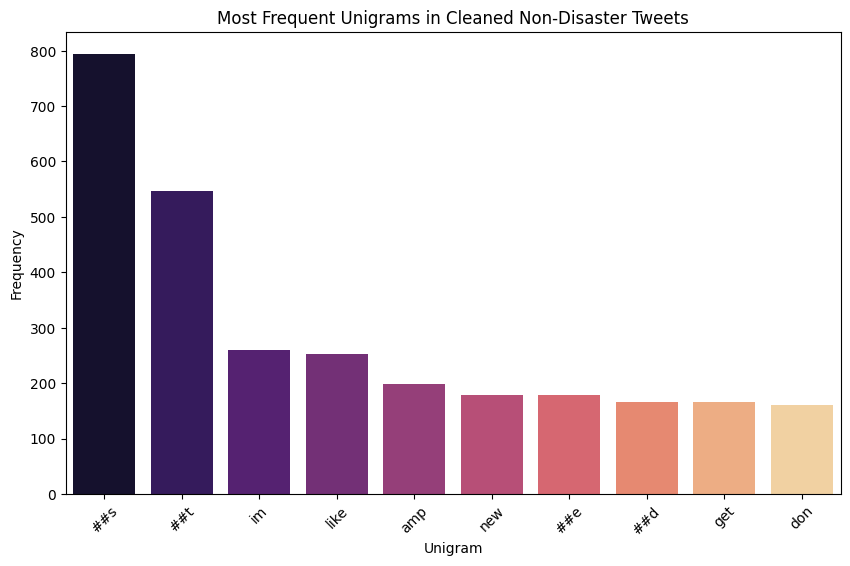

<ipython-input-29-c591c14b550d>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[pair[0] for pair in clean_disaster_unigram_freq.most_common(10)],


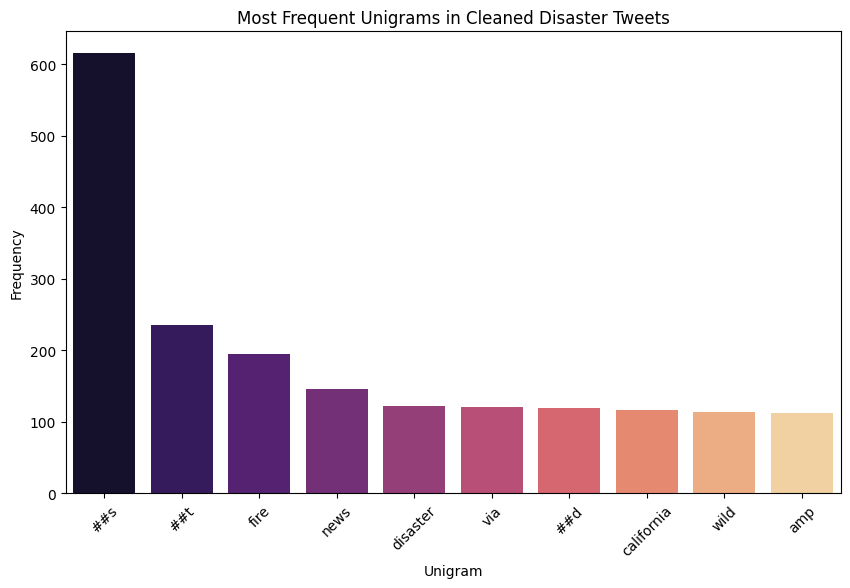

In [ ]:
# Calculate the frequency of each unigram for cleaned data
clean_non_disaster_unigram_freq = Counter([token for sublist in non_disaster_tokenized_texts_cleaned for token in sublist])
clean_disaster_unigram_freq = Counter([token for sublist in disaster_tokenized_texts_cleaned for token in sublist])

# Plot the most frequent unigrams for cleaned non-disaster tweets
plt.figure(figsize=(10, 6))
sns.barplot(x=[pair[0] for pair in clean_non_disaster_unigram_freq.most_common(10)],
            y=[pair[1] for pair in clean_non_disaster_unigram_freq.most_common(10)],
            palette='magma')
plt.title('Most Frequent Unigrams in Cleaned Non-Disaster Tweets')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

# Plot the most frequent unigrams for cleaned disaster tweets
plt.figure(figsize=(10, 6))
sns.barplot(x=[pair[0] for pair in clean_disaster_unigram_freq.most_common(10)],
            y=[pair[1] for pair in clean_disaster_unigram_freq.most_common(10)],
            palette='magma')
plt.title('Most Frequent Unigrams in Cleaned Disaster Tweets')
plt.xlabel('Unigram')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()
